In [2]:
import xarray as xr
import pickle
import math
from pyproj import CRS, Transformer
import pyproj
import numpy as np
# import xesmf as xe
import matplotlib.pyplot as plt
import fsspec
from cfgrib import xarray_to_grib

In [ ]:
def calc_heading(lat1, lon1, lat2, lon2):

    lat1_rad = np.deg2rad(lat1)
    lat2_rad = np.deg2rad(lat2)
    lon1_rad = np.deg2rad(lon1)
    lon2_rad = np.deg2rad(lon2)

    d_lon = lon2_rad - lon1_rad

    y = np.sin(d_lon) * np.cos(lat2_rad)
    x = (np.cos(lat1_rad) * np.sin(lat2_rad) -
         np.sin(lat1_rad) * np.cos(lat2_rad) * np.cos(d_lon)) 
    
    initial_bearing_rad = np.arctan2(y, x)

    initial_bearing_deg = np.rad2deg(initial_bearing_rad)

    bearing = (initial_bearing_deg + 360) % 360

    return bearing 

def rotate_point_around_origin(x, y, angle):
    """
    Rotates a 2D point (x, y) around the origin (0, 0) by a given angle.

    Args:
        x (float): The x-coordinate of the point.
        y (float): The y-coordinate of the point.
        angle_radians (float): The angle of rotation in radians (counter-clockwise).

    Returns:
        tuple: A tuple (new_x, new_y) representing the rotated point.
    """
    angle = np.deg2rad(angle)
    new_x = x * math.cos(angle) - y * math.sin(angle)
    new_y = x * math.sin(angle) + y * math.cos(angle)
    return new_x, new_y

In [ ]:
calc_heading(30, -100, 35, -110)

In [ ]:
def to_polar(
        ds: xr.Dataset,
        origin_lat: float,
        origin_lon: float,
        ref_lat: float,
        ref_lon: float,
        rho_steps: int,
        theta_steps: int
    ) -> xr.Dataset:
    
        R = 6378137 # radius of Earth in meters
        R_max = 250.0 # Max range in km
        R_step = 0.5  # Range step in km
        A_step = 0.5  # Azimuth step in degrees

        new_range = np.arange(0.0, R_max + R_step, R_step)
        new_azimuth = np.arange(0.0, 360.0, A_step)
        R, T = np.meshgrid(new_azimuth, new_range, indexing = 'ij')

        heading_shift = calc_heading(origin_lat, origin_lon, ref_lat, ref_lon)
        print(heading_shift)
     
        X = R * np.cos(T) * 1000 # Convert km to meters
        Y = R * np.sin(T) * 1000
        local_proj_str = f"+proj=aeqd +lat_0={origin_lat} +lon_0={origin_lon} +units=m"
        transformer = pyproj.Transformer.from_crs(local_proj_str, "EPSG:4326", always_xy=True)

        X,Y = rotate_point_around_origin(X, Y, heading_shift)
        target_lons, target_lats = transformer.transform(X, Y)
        
        # print("Target Lats: " + str(np.shape(target_lats)))
        # print("Target Lons: " + str(np.shape(target_lons)))
        # print("range: " + str(np.shape(new_range)))
        # print("azimuth: " + str(np.shape(new_azimuth)))

        # print("New Range: " + str(new_range.max()))
        # print("New Angle: " + str(new_azimuth.max()))
        ds_out = xr.Dataset(
                            coords={
                                    "latitude": (("angle", "radius"), target_lats),
                                    "longitude": (("angle", "radius"), target_lons),
                                    "radius": new_range,
                                    "angle": new_azimuth
                                        }
                            )
        regridder = xe.Regridder(ds, ds_out, 'bilinear')
        polar_out = regridder(ds)
       
       
        
        
        return polar_out



In [2]:
# 92l.2023082400
# 13l.2025102712
uri = "simplecache::s3://noaa-nws-hafs-pds/hfsa/20230707/12/93e.2023070712.hfsa.storm.atm.f027.grb2"

file = fsspec.open_local(uri, s3={'anon': True}, filecache={'cache_storage':'/tmp/files'})

drop_variables = ['q', 'w', 'wz', 'absv', 'clwmr', 'icmr', 'rwmr', 'snmr','grle', 'rare']
ds_atm = xr.open_dataset(file,
                         drop_variables = drop_variables, 
                         filter_by_keys={'typeOfLevel': 'isobaricInhPa', 'level': [700]},
                         engine='cfgrib'
                        )           

# ds_sfc = xr.open_dataset(file,
#                          drop_variables = drop_variables,  
#                          filter_by_keys={'typeOfLevel': 'meanSea'},
#                          engine='cfgrib',
#                         chunks = 'auto')

NameError: name 'fsspec' is not defined

In [ ]:
if c_msp > 990:
    print('hi')

In [ ]:
min_coords.latitude.values

In [28]:
np.nanmax(ds_atm['gh'].values)

np.float32(3161.379)

In [ ]:
pol_ds = to_polar(ds = ds_atm.isel(longitude = slice(100,-100)).squeeze(), origin_lat = min_coords.latitude.values, origin_lon = min_coords.longitude.values, ref_lat = 18, ref_lon= 280, theta_steps = 720, rho_steps = 1100 )

In [ ]:
print(pol_ds.latitude.shape)
pol_ds = pol_ds.sel(radius = slice(0,100), drop = True)
print(pol_ds.latitude.shape)

In [ ]:
rol_pol = pol_ds.roll(radius = 360, roll_coords = True)

In [ ]:
len(pol_ds.angle)

In [ ]:
# fig, ax = plt.subplots(figsize=(8, 6),subplot_kw={'projection': 'polar'})

# R, Theta = np.meshgrid(rol_pol.radius.values, rol_pol.angle.values)


# ax.pcolormesh(R, Theta, pol_ds['prmsl'].values[:-1,:-1])
 

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6),subplot_kw={'projection': 'polar'})

R, Theta = np.meshgrid(pol_ds.radius.values, pol_ds.angle.values)


ax.pcolormesh(R, Theta, pol_ds['t'].sel(isobaricInhPa = 850).values[:-1,:-1])

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6),subplot_kw={'projection': 'polar'})

R, Theta = np.meshgrid(pol_ds.radius.values, pol_ds.angle.values)


ax.pcolormesh(R, Theta, pol_ds['t'].sel(isobaricInhPa = 850).values[:-1,:-1])

In [2]:
ds = xr.open_dataset('test.nc')

In [3]:
ds1 = ds.isel(concat_dim = 0)

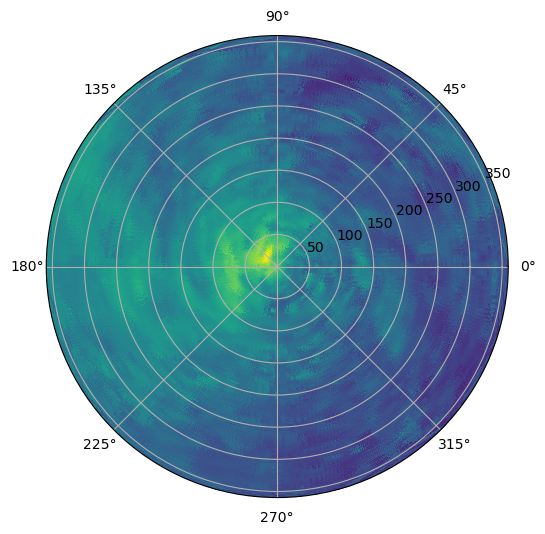

In [15]:
fig, ax = plt.subplots(figsize=(8, 6),subplot_kw={'projection': 'polar'})

R, Theta = np.meshgrid(ds1.radius.values, ds1.angle.values)


ax.pcolormesh(R, Theta, ds1['t'].values[:-1,:-1])

In [16]:
xarray_to_grib.canonical_dataset_to_grib(ds_atm, 'test.grib')

c:\Users\Ian\anaconda3\envs\ATMS523Proj\Lib\site-packages\cfgrib\xarray_to_grib.py:253: FutureWarning: GRIB write support is experimental, DO NOT RELY ON IT!
  warnings.warn("GRIB write support is experimental, DO NOT RELY ON IT!", FutureWarning)


AttributeError: module 'xarray.backends.api' has no attribute '_validate_dataset_names'

In [29]:
np.nanmax(np.sqrt(ds_atm['u'].values**2 + ds_atm['v'].values**2))

np.float32(36.428562)

In [1]:
ds_atm

NameError: name 'ds_atm' is not defined